<a href="https://colab.research.google.com/github/hernanmorales-navarrete/EPIC_5/blob/main/Tutorials/tutorial_6/code/1_Image_analysis_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BioImage Analysis with Python

- This is a tutorial on the basics of bioimage analysis with Python (i.e. the analysis of fluorescence microscopy data)
- It is a step by step pipeline for segmenting cells in 2D fluorescence microscopy images (with labeled membranes)
- These materials have been adapted from the original versions:
    - "Python BioImage Analysis Tutorial:" https://github.com/WhoIsJack/python-bioimage-analysis-tutorial
    - "Python Workshop - Image Processing" : https://github.com/karinsasaki/python-workshop-image-processing

## 1. Importing Modules & Packages

In [1]:
# NumPy :  manipulation of numerical arrays:
import numpy as np

# The plotting module matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# The image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

In [2]:
# Set matplotlib backend
%matplotlib inline
#%matplotlib inline              # Displays as static figure in code cell output
#%matplotlib notebook            # Displays as interactive figure in code cell output
#%matplotlib qt                  # Displays as interactive figure in a separate window


## 2. Loading Image Data

In [3]:
# Create string variables for the path and the name of the file to load (r before your string creates a 'raw string')

filename = r'cells_2D.tif'
print('Image name : ', filename)

dirpath = r'https://raw.githubusercontent.com/ciencialatitud0/EPIC_5/main/Tutorials/tutorial_6/images/'
print('Image path : ', dirpath)


Image name :  cells_2D.tif
Image path :  https://raw.githubusercontent.com/ciencialatitud0/EPIC_5/main/Tutorials/tutorial_6/images/


In [4]:
# Combine the directory path and file name into one variable, the file path
# Import the function 'join' from the module 'os.path': combining two paths.
from os.path import join
filepath = join(dirpath, filename)
print('Image full path : ', filepath)

Image full path :  https://raw.githubusercontent.com/ciencialatitud0/EPIC_5/main/Tutorials/tutorial_6/images/cells_2D.tif


In [5]:
# Load the image

# Import the function 'imread' from the module 'skimage.io'.
from skimage.io import imread

# Alternatively :
# from tifffile import imread

img = imread(filepath)

In [6]:
# Create function for plotting

def myplt(img, title):
    """This function displays the input image with interpolation='none', cmap='magma' in the range of 0-255 (8-bits). """
    plt.imshow(img,interpolation='none',cmap='magma', vmin=0, vmax=255)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(title)


Variable Type:  <class 'numpy.ndarray'>
Image data type:  uint8
Image dimension:  (930, 780)


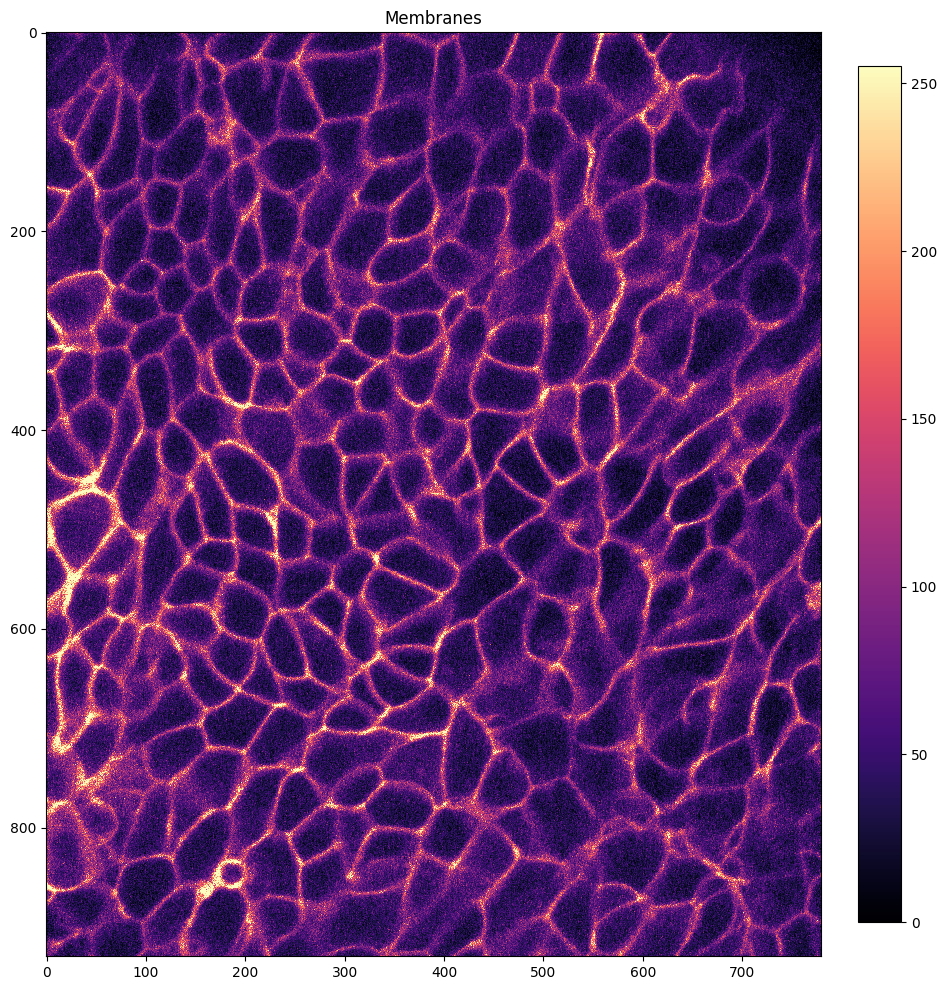

In [7]:
# Plot image and diplay image features

print('Variable Type: ', type(img))
print('Image data type: ', img.dtype)
print('Image dimension: ', img.shape)
plt.figure(figsize=(12,12))
myplt(img, "Membranes")
plt.show()


## 3. Image Preprocessing

### Image Filtering

- Removing noise and preserving the structures of interest.

- Genereal noised reduction (smoothing) using a `Gaussian filter`

- Gaussian Smoothing : Gaussian kernel is determined by the standard deviation ($\sigma$) of the Gaussian distribution
- $\sigma$ : large enough to blur out noise but small enough to keep structures of interest

In [ ]:
# Test for several values for the smoothing factor sigma
# note: range(start_value, end_value, step)
# Use the Gaussian filter function 'ndi.filters.gaussian_filter' from the 'scipy.ndimage'

plt.figure(figsize=(16,16))
for sigma in range(1, 5, 1):
    img_smooth_test = ndi.filters.gaussian_filter(img, sigma)
    plt.subplot(2,2,sigma)
    txt = "$\sigma$ =" + str(sigma)
    myplt(img_smooth_test, txt)


In [ ]:
# 'Zoom-in' a specific region of the image

plt.figure(figsize=(12,12))
for sigma in range(1, 5, 1):
    img_smooth_test = ndi.filters.gaussian_filter(img[150:200, 150:200], sigma)
    plt.subplot(2,2,sigma)
    txt = "$\sigma$ =" + str(sigma)
    myplt(img_smooth_test, txt)


In [ ]:
# Function to plot pairs of images

def pltPair(img1, img2, title1, title2, cmap1, cmap2, lim):
    """This function displays a pair of input image with interpolation='none',in the range of lims. """

    plt.figure(figsize=(16,16))
    plt.subplot(1,2,1)
    plt.imshow(img1, interpolation='none', cmap=cmap1, vmin=lim[0], vmax=lim[1])
    plt.title(title1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,2,2)
    plt.imshow(img2, interpolation='none', cmap=cmap2, vmin=lim[2], vmax=lim[3])
    plt.title(title2)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

In [ ]:
#  Show the raw and smoothed images side by side using 'plt.subplots'

sigma = 1
img_smooth = ndi.filters.gaussian_filter(img, sigma)

pltPair(img, img_smooth, 'Raw Image', 'Smoothed Image with '+"$\sigma$ =" + str(sigma), 'magma', 'magma', [0,255,0,255])

## 4. Foreground detection

#### Manual Thresholding

In [ ]:
# (i) Create a variable for a manually set threshold, which should be an integer

thres = 70

mem = img_smooth > thres
print('Thresholded image is type : ', mem.dtype)

pltPair(img_smooth, mem, 'Smoothed Image', 'Thresholded Membranes with thres =' + str(thres), 'magma', 'gray', [0,255,0,1])



In [ ]:
# Try out different thresholds to find the best one using 'widgets' for interactive selection

# Prepare widget
from ipywidgets import interact
@interact(thresh=(10,250,10))
def select_threshold(thresh=100):

    # Thresholding
    mem = img_smooth > thresh

    # Visualization
    pltPair(img_smooth, mem, 'Smoothed Image', 'Thresholded Membranes with thresh =' + str(thresh), 'magma', 'gray', [0,255,0,1])



----

*For some users, it is necessary to specifically activate the widgets plugin for Jupyter notebook. To do so, save and exit Jupyter notebook, then go to a terminal and write `jupyter nbextension enable --py --sys-prefix widgetsnbextension`.

#### Automatic Thresholding

- There are several algorithm for autoimatic thrshold detection
- 'skimage.filters.thresholding' provides several threshold detection algorithms
- One of the most popular : Otsu's method.

In [ ]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Calculate and apply threshold
thresh = threshold_otsu(img_smooth)
mem = img_smooth > thresh
print('Throshold by Otsu = ', str(thresh))

# Visualization
pltPair(img_smooth, mem, 'Smoothed Image', 'Thresholded Membranes with Otsu', 'magma', 'gray', [0,255,0,1])



In [ ]:
# You can asl try all algorithms aviable in 'skimage.filters.thresholding'
from skimage.filters.thresholding import try_all_threshold
fig = try_all_threshold(img_smooth, figsize=(12,12), verbose=False)

#### Adaptive Thresholding

- Adaptive thresholding algorithm, which adjusts the threshold locally in different regions of the image to account for varying intensities
- scikit-image provides a function for adaptive thresholding called threshold_local
- Here step by step :
    - Generation of a "background image"
    - Thresholding of the original image with the background

In [ ]:
# Generation of a "background image"

# Generate a blurred image with large sigma
largeSigma = 19
bg = ndi.filters.gaussian_filter(img_smooth, largeSigma)

# Vizualization
pltPair(img_smooth, bg, 'Smoothed Image', 'Background image', 'magma', 'magma', [0,255,0,255])

In [ ]:
# Threshold the smoothed original image against the background image

mem = img_smooth > bg

# Visualization
pltPair(img_smooth, mem, 'Smoothed Image', 'Adaptative Threshold', 'magma', 'gray', [0,255,0,1])



## 5. Binary Morphological operations
 - Improving masks
 - Morphological operations such as erosion, dilation, closing and opening
 - Fill small holes, remove noise, increase or decrease the size of an object
 - Simple kernel functions that are applied at each pixel of the image based on their neighborhood as defined by a structuring element (SE)
 - Dilation assigns to the central pixel the maximum pixel value within the neighborhood (maximun filter)
 - Erosion is a minimum filter.

In [ ]:
# Remove speckles using binary hole filling

# Use the function 'ndi.binary_fill_holes' for this. Be sure to check the docs to
# understand exactly what it does. For this to work as intended, you will have to
# invert the mask, which you can do using the function `np.logical_not` or the
# corresponding operator '~'. Again, be sure to understand why this has to be done
# and don't forget to revert the result back.

#mem_holefilled = np.logical_not(ndi.binary_fill_holes(np.logical_not(mem)))  # Long form
mem_final = ~ndi.binary_fill_holes(~mem)  # Short form

# Visualization
pltPair(mem, mem_final, 'Binary Image', 'Binary Image after filling holes', 'gray', 'gray', [0,1,0,1])


## 6. Cells segmentation

###  Connected Components Labeling

- Goal identify individual cells as single objects (with unique ID)
- Using 'connected components labeling'. It gives every connected group of foreground pixels a unique ID number.

In [ ]:
# Label connected components

# Use the function 'ndi.label' from the 'ndimage' module.

cell_labels, _ = ndi.label(~mem_final)

iMax = cell_labels.max();
print(str(iMax), ' cells detected')
pltPair(mem_final, cell_labels,'Membranes', 'Cell Labels', 'gray', 'jet', [0,1,0,iMax])

### Seeding and Expansion

- Expansion algorithms such as the watershed start from a small seed and "grow outward" until they touch the boundaries of neighboring cells

#### Seeding by Distance Transform
- A `seed image` contains a few pixels at the center of each cell labeled by a unique `ID` number
- If Nuclei image is avaible, use it as seeds
- Alternatively:  `distance transform` and `local maxima` for seeding

In [ ]:
# Run a distance transform on the membrane mask
# Use the function 'ndi.distance_transform_edt'.

dist_trans = ndi.distance_transform_edt(~mem_final)
dMax = dist_trans.max();
pltPair(mem_final, dist_trans,'Membranes', 'Distance Transform', 'gray', 'magma', [0,1,0,dMax])

In [ ]:
# Smoothen the distance transform

dist_trans_smooth = ndi.filters.gaussian_filter(dist_trans, sigma=5)
dMax = dist_trans_smooth.max();
pltPair(mem_final, dist_trans_smooth,'Membranes', 'Distance Transform Smooth', 'gray', 'magma', [0,1,0,dMax])


In [ ]:
# Get the local maxima from the distance transform
# Use the function 'peak_local_max' from the module 'skimage.feature'.

from skimage.feature import peak_local_max
seeds = peak_local_max(dist_trans_smooth, indices=False,  min_distance=10)

# Dilate seeds : for vizualization
seeds_dil = ndi.filters.maximum_filter(seeds, size=10)

pltPair(img_smooth, seeds_dil, 'Smooth image', 'Seeds', 'gray', 'jet', [0,255,0,1])

In [ ]:
# Visualize the output as an overlay on the smoothed image


plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap='autumn')
plt.show()

In [ ]:
# Label the seeds using connected component

# Use connected component labeling to give each cell seed a unique ID number.
seeds_labeled,_ = ndi.label(seeds)

# Visualize the final result
seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10)  # Expand a bit for visualization
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0), interpolation='none', cmap='prism')
plt.show()

#### Expansion by Watershed

In [ ]:
# Perform watershed
# Use the function 'watershed' from the module 'skimage.morphology'.

from skimage.segmentation import watershed
ws = watershed(img_smooth, seeds_labeled)

nCells0 = ws.max();
print(str(nCells0), ' cells detected')
pltPair(img_smooth, ws, 'Smooth image', 'Watershed', 'gray', 'jet', [0,255,0,nCells0])
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='prism', alpha=0.4)
plt.show()

## 7. Postprocessing

###  Removing Cells at the Image Border

In [ ]:
# Create an image border mask

border_mask = np.zeros(ws.shape, dtype=bool)
border_mask = ndi.binary_dilation(border_mask, border_value=1)

# Remove the cells at the border

# Create a copy of the initial result
clean_ws = np.copy(ws)

for cell_ID in np.unique(ws):

    # Create a mask that contains only the 'current' cell of the iteration
    cell_mask = ws==cell_ID

    # Use the cell mask and the border mask to test if the cell has pixels touching
    # the image border or not.
    cell_border_overlap = np.logical_and(cell_mask, border_mask)  # Overlap of cell mask and boundary mask
    total_overlap_pixels = np.sum(cell_border_overlap)            # Sum overlapping pixels

    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    if total_overlap_pixels > 0:
        clean_ws[cell_mask] = 0

# Re-label the remaining cells to keep the numbering consistent from 1 to N (with 0 as background).

for new_ID, cell_ID in enumerate(np.unique(clean_ws)[1:]):  # The [1:] excludes 0 from the list (background)!
    clean_ws[clean_ws==cell_ID] = new_ID+1                  # The same here for the +1

nCells = clean_ws.max();
print(str(nCells), ' cells detected after removing the ones at the border')
pltPair(ws, clean_ws, 'Cells initial', 'Cells final', 'jet', 'jet', [0,255,0,nCells])
plt.show()


### Identifying Cell Edges

- Create cell edge mask
- For each cell:
    - Erode the cell's mask by 1 pixel
    - Using the eroded mask and the original mask, create a new mask of only the cell's edge pixels

In [ ]:
# Create cell edge mask
edges = np.zeros_like(clean_ws)

# Iterate over the cell IDs
for cell_ID in np.unique(clean_ws)[1:]:

    # Erode the cell's mask by 1 pixel using 'ndi.binary_erode'
    cell_mask = clean_ws==cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1) #

    # Create the cell edge mask using 'np.logical_xor'
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)

    # Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    edges[edge_mask] = cell_ID

# Vizualize
maskEdges = np.ma.array(edges, mask=edges==0)
pltPair(img_smooth[100:200, 100:200], maskEdges[100:200, 100:200], 'Smooth image', 'Cell edges', 'gray', 'prism', [0,255,0,nCells])
plt.show()

## 8. Extracting Quantitative Measurements

Measure different properties of cells:

- Cell ID
- Mean intensity of each cell
- Mean intensity at the membrane of each cell
- The cell area, i.e. the number of pixels that make up the cell
- The cell outline length, i.e. the number of pixels that make up the cell edge


In [ ]:
# Create a dictionary that contains a key-value pairing for each measurement

results = {"cell_id"      : [],
           "int_mean"     : [],
           "int_mem_mean" : [],
           "cell_area"    : [],
           "cell_edge"    : []}


# Run calculations for each cell

for cell_id in np.unique(clean_ws)[1:]:

    # Mask the current cell and cell edge
    cell_mask = clean_ws==cell_id
    edge_mask = edges==cell_id

    # Get the measurements
    results["cell_id"].append(cell_id)
    results["int_mean"].append(np.mean(img[cell_mask]))
    results["int_mem_mean"].append(np.mean(img[edge_mask]))
    results["cell_area"].append(np.sum(cell_mask))
    results["cell_edge"].append(np.sum(edge_mask))

# Print the results
for key in results.keys():
    print(key + ":", results[key][:5], '\n')

## Analysis & Visualisation

In [ ]:
# (i) Get summarize the results


# Custom function for printing of summary statistics.
# Note the use of format strings for nice number padding.
def print_summary(data):
    print( "  Mean:    {:7.2f}".format(np.mean(data))   )
    print( "  Stdev:   {:7.2f}".format(np.std(data))    )
    print( "  Max:     {:7.2f}".format(np.max(data))    )
    print( "  Min:     {:7.2f}".format(np.min(data))    )
    print( "  Median:  {:7.2f}".format(np.median(data)) )

# Calling the custom function for each dataset
for key in results.keys():
    print( '\n'+key )
    print_summary(results[key])


In [ ]:
# Using  pre-made functions to get summary statistics : 'scipy.stats.describe'.
from scipy.stats import describe
stat_summary = describe(results['int_mean'])

print( '\nscipy.stats.describe of int_mean' )
for key in stat_summary._asdict().keys():
    print( ' ', key+': ', stat_summary._asdict()[key] )

In [ ]:
# Create a box plot showing the mean cell and mean membrane intensities  using 'plt.boxplot'.

plt.figure(figsize=(3,6))
plt.boxplot([results['int_mean'], results['int_mem_mean']],
            labels=['int_mean', 'int_mem_mean'],
            widths=0.6, notch=True)
plt.show()

In [ ]:
# Scatter plot of cell outline length over cell area using 'plt.scatter'

plt.figure(figsize=(8,5))
plt.scatter(results["cell_area"], results["cell_edge"],
            edgecolor='k', s=30, alpha=0.5)
plt.xlabel("cell area [pxl^2]")
plt.ylabel("cell edge length [pxl]")

cell_area_range = np.linspace(min(results["cell_area"]), max(results["cell_area"]), num=100)
circle_circumference = 2 * np.pi * np.sqrt( cell_area_range / np.pi )
plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['circles', 'data'], loc=2, fontsize=10)
plt.show()

In [ ]:
# Map the cell area back onto the image as a 'heatmap'

# 'Normalized' area for vizualization
areas_8bit = np.array(results["cell_area"]) / max(results["cell_area"]) * 255

area_map = np.zeros_like(clean_ws, dtype=np.uint8)

# Iterate over the segmented cells.

for index, cell_id in enumerate(results["cell_id"]):
    # Mask the current cell and assign the cell's (re-scaled) area value to the cell's pixels.
    area_map[clean_ws==cell_id] = areas_8bit[index]


# Create the plot
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(area_map,interpolation='none', cmap='jet', alpha=0.6)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()